In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import GPyOpt
import random
from IPython.display import clear_output
import time

In [2]:
# set seeds 
seed=42
random.seed(seed)  # Python
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch
torch.cuda.manual_seed_all(seed)  # PyTorch CUDA

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR10 datasets
data_dir = '../CIFAR10_data'
full_dataset = datasets.CIFAR10(data_dir, download=True, train=True, transform=transform)

# Define the size of the subsets for active learning
initial_training_size = 500  # Start with a small training set
val_subset_size = 800  # Define validation set size

# Determine the size for the unlabeled pool
total_subset_size = len(full_dataset) - val_subset_size  # Rest of the data for unlabeled pool
unlabeled_pool_size = total_subset_size - initial_training_size

# Shuffle and split the indices for datasets
indices = np.random.permutation(len(full_dataset))
train_indices = indices[:initial_training_size]
unlabeled_indices = indices[initial_training_size:initial_training_size + unlabeled_pool_size]
val_indices = indices[initial_training_size + unlabeled_pool_size:]

# Create subset datasets
trainset = Subset(full_dataset, train_indices)
unlabeled_pool = Subset(full_dataset, unlabeled_indices)
valset = Subset(full_dataset, val_indices)

# Create DataLoaders from the subset datasets with appropriate batch sizes
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_pool, batch_size=32, shuffle=False)  # Typically no need to shuffle the unlabeled pool
val_loader = DataLoader(valset, batch_size=32, shuffle=False)

Files already downloaded and verified


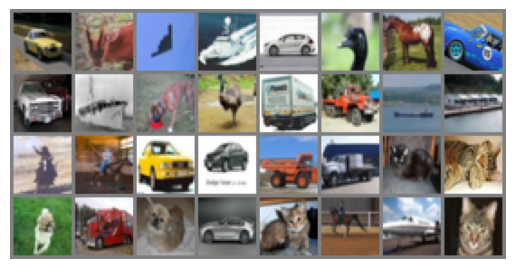

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# example showcase
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images))

# CNN architecture

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # CIFAR-10 images are 3-channel (RGB) 32x32 images
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer to reduce spatial dimensions
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # After two pooling layers, the image size will be reduced to 8x8 (32 -> 16 -> 8)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training & evaluation

In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set model to training mode
    epoch_losses = []  # Collect average loss per epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)  # Store the average loss for this epoch
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

    clear_output(wait=True)  # Clear the output to keep it concise
    return epoch_losses  # Return the list of average losses per epoch

In [7]:
# Function to evaluate the model
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluation", leave=False):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy * 100

# Random sampling

In [8]:
def random_sampling_training(model, full_dataset, initial_train_indices, unlabeled_indices, val_loader, criterion, optimizer, num_epochs=10, num_iterations=5, num_samples=100):
    train_indices = list(initial_train_indices)
    unlabeled_indices = list(unlabeled_indices)
    accuracies = []

    for iteration in tqdm(range(num_iterations), desc='Random Sampling Iteration'):
        # Randomly select new samples to add to the training set
        new_samples = np.random.choice(unlabeled_indices, num_samples, replace=False)
        train_indices.extend(new_samples)
        unlabeled_indices = [idx for idx in unlabeled_indices if idx not in new_samples]

        # Update the training dataset and loader
        train_dataset = Subset(full_dataset, train_indices)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Train and evaluate
        train_model(model, train_loader, criterion, optimizer, num_epochs)
        accuracy = evaluate_model(model, val_loader)
        accuracies.append(accuracy)

    print("Completed random sampling training")
    return accuracies

# Uncertainty sampling

In [9]:
def uncertainty_sampling(model, full_dataset, train_indices, unlabeled_indices, val_loader, criterion, optimizer, num_epochs=10, num_iterations=5, num_samples=100):
    accuracies = []  # To store accuracy after each iteration for plotting
    train_indices = list(train_indices)  # Convert to list if they are numpy arrays
    unlabeled_indices = list(unlabeled_indices)

    for iteration in tqdm(range(num_iterations), desc='AL Iteration'):
        # Create data loaders for current subsets
        train_dataset = Subset(full_dataset, train_indices)
        unlabeled_dataset = Subset(full_dataset, unlabeled_indices)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

        # Train and evaluate
        train_model(model, train_loader, criterion, optimizer, num_epochs)
        accuracy = evaluate_model(model, val_loader)
        accuracies.append(accuracy)

        # Uncertainty prediction and sampling
        model.eval()  # Set model to evaluation mode
        uncertainties = []
        with torch.no_grad():
            for images, _ in tqdm(unlabeled_loader, desc='Predicting Uncertainty', leave=False):
                outputs = model(images)
                probabilities = F.softmax(outputs, dim=1)
                uncertainty = -torch.sum(probabilities * torch.log(probabilities), dim=1)
                uncertainties.append(uncertainty)

        uncertainties = torch.cat(uncertainties)
        _, uncertain_sample_indices = torch.topk(uncertainties, num_samples, largest=True)
        uncertain_sample_indices = uncertain_sample_indices.tolist()

        # Update train and unlabeled indices for the next iteration
        train_indices += [unlabeled_indices[i] for i in uncertain_sample_indices]
        unlabeled_indices = [i for j, i in enumerate(unlabeled_indices) if j not in uncertain_sample_indices]

    print("Completed uncertainty sampling training.")
    return accuracies

# Comparison of random sampling vs uncertainty sampling

Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy: 45.25%


Predicting Uncertainty:   0%|          | 0/1510 [00:00<?, ?it/s]

Completed uncertainty sampling training.


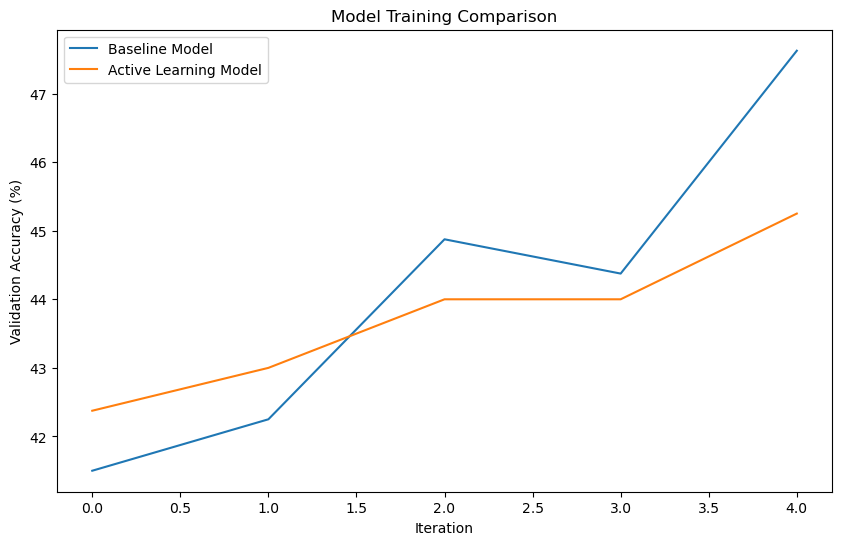

In [11]:
# Showtime
# Correct parameter setup
num_epochs = 10
num_iterations = 5  # The number of cycles you want to run in active learning and random sampling
num_samples = 100  # How many samples to add each time

# Initialize models
baseline_model = CNN()
al_model = CNN()

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Initialize optimizers
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
al_optimizer = optim.Adam(al_model.parameters(), lr=0.001)

# Define initial_train_indices
initial_train_indices = np.random.choice(len(full_dataset), size=initial_training_size, replace=False)

# Train the baseline model using random sampling
baseline_accuracies = random_sampling_training(baseline_model, full_dataset, initial_train_indices, unlabeled_indices, val_loader, criterion, baseline_optimizer, num_epochs, num_iterations, num_samples)

# Train the AL model using uncertainty sampling
al_accuracies = uncertainty_sampling(al_model, full_dataset, initial_train_indices, unlabeled_indices, val_loader, criterion, al_optimizer, num_epochs, num_iterations, num_samples)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), baseline_accuracies, label='Baseline Model')
plt.plot(range(num_iterations), al_accuracies, label='Active Learning Model')
plt.title("Model Training Comparison")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.show()